In [1]:
# dependencies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Model, Input, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam # not important as there's no training here.
import tensorflow as tf
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


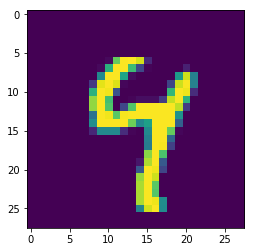

In [3]:
plt.imshow(mnist.train.images[2].reshape(28,28))
plt.show()

In [4]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

input_shape = (img_rows, img_cols, 1)

In [5]:
# x_train = mnist.train.images.reshape(-1, img_rows, img_cols, 1)
# x_valid = mnist.validation.images.reshape(-1, img_rows, img_cols, 1)
# x_test = mnist.test.images.reshape(-1, img_rows, img_cols, 1)

x_train = mnist.train.images
x_valid = mnist.validation.images
x_test = mnist.test.images
print(np.shape(x_train))
print(np.shape(x_valid))
print(np.shape(x_test))

(55000, 784)
(5000, 784)
(10000, 784)


In [6]:
y_train = mnist.train.labels
y_valid = mnist.validation.labels
y_test = mnist.test.labels
print(np.shape(y_train))
print(np.shape(y_valid))
print(np.shape(y_test))

(55000, 10)
(5000, 10)
(10000, 10)


In [7]:
input_layer = Input(shape=(784,))
layer_1 = Dense(784)(input_layer)
output_layer = Dense(num_classes, activation='softmax')(layer_1)
model = Model(input_layer, output_layer)
model.compile(Adam(), 'mse', metrics=['accuracy'])



# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(optimizer= Adam(), loss='mse')



# input_layer = Input(shape=(5,1))
# layer = Dense(8)(input_layer)
# output_layer = Dense(3)(layer)
# model = Model(input_layer, output_layer)
# model.compile(Adam(), 'mse')

In [8]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 784) dtype=float32>

In [9]:
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_test, y_test))

In [21]:
class EvolutionStrategy(object):

    def __init__(self, weights, get_reward_func, population_size=50, sigma=0.1, learning_rate=0.001):
        np.random.seed(0)
        self.weights = weights
        self.get_reward = get_reward_func
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate


    def _get_weights_try(self, w, p):
        weights_try = []
        for index, i in enumerate(p):
            jittered = self.SIGMA*i
            weights_try.append(w[index] + jittered)
        return weights_try


    def get_weights(self):
        return self.weights


    def run(self, iterations, print_step=10):
        for iteration in range(iterations):

            if iteration % print_step == 0:
                print('iter %d. reward: %f' % (iteration, self.get_reward(self.weights)))

            population = []
            rewards = np.zeros(self.POPULATION_SIZE)
            for i in range(self.POPULATION_SIZE):
                x = []
                for w in self.weights:                 
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            
            for i in range(self.POPULATION_SIZE):
                weights_try = self._get_weights_try(self.weights, population[i])
                rewards[i]  = self.get_reward(weights_try)
            
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)

            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = w + self.LEARNING_RATE/(self.POPULATION_SIZE*self.SIGMA) * np.dot(A.T, rewards).T

In [22]:
def get_reward(weights):
    start_index = np.random.choice(y_train.shape[0]-batch_size-1,1)[0]
    solution = y_train[start_index:start_index+batch_size]
    inp = x_train[start_index:start_index+batch_size]
    
    model.set_weights(weights)
    prediction = model.predict(inp)
    #print(prediction)

    #accuracy = (np.mean(np.equal(np.argmax(prediction), np.argmax(solution))))
    #print('accuracy:', accuracy)

    reward = -np.sum(np.square(solution - prediction))
    #reward = np.mean(np.equal(np.argmax(prediction), np.argmax(solution)))
    return reward

# def get_reward(weights):
#     solution = np.array([0.5, 0.1, -0.3])
#     inp = np.asarray([[1,2,3,4,5]])
#     inp = np.expand_dims(inp, -1)
    
#     model.set_weights(weights)
#     prediction = model.predict(inp)[0]
#     # here our best reward is zero
#     reward = -np.mean(np.square(solution - prediction))
#     return reward

In [23]:
for i in model.get_weights():
    print(i.shape)

(784, 784)
(784,)
(784, 10)
(10,)


In [24]:
es = EvolutionStrategy(model.get_weights(), get_reward, population_size=50, sigma=0.1, learning_rate=0.001)
es.run(1000, print_step=10)

iter 0. reward: -117.537794
iter 10. reward: -115.959539
iter 20. reward: -114.769395
iter 30. reward: -115.323557
iter 40. reward: -115.024518
iter 50. reward: -112.120282
iter 60. reward: -111.588756
iter 70. reward: -108.683120
iter 80. reward: -108.715734
iter 90. reward: -106.373435
iter 100. reward: -105.847861
iter 110. reward: -103.307791
iter 120. reward: -98.713469
iter 130. reward: -104.438891
iter 140. reward: -99.905645
iter 150. reward: -97.672412
iter 160. reward: -105.081657
iter 170. reward: -99.912359
iter 180. reward: -101.594007
iter 190. reward: -93.135164
iter 200. reward: -101.110040
iter 210. reward: -97.058952
iter 220. reward: -95.576623
iter 230. reward: -86.673647
iter 240. reward: -87.290171
iter 250. reward: -82.205154
iter 260. reward: -84.573878
iter 270. reward: -78.463883
iter 280. reward: -80.094559
iter 290. reward: -78.969926
iter 300. reward: -87.946822
iter 310. reward: -83.135224
iter 320. reward: -87.582897
iter 330. reward: -81.248430
iter 340.

In [25]:
# Test set prediction
pediction = model.predict(x_test)
solution = y_test
np.mean(np.equal(np.argmax(pediction,1), np.argmax(solution,1)))

0.3921

In [15]:
start_index = np.random.choice(y_train.shape[0]-batch_size,1)[0]
start_index

42241

In [16]:
start_index-1

42240

In [19]:
y_train[54871:54871+batch_size]

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [18]:
y_train.shape[0]-batch_size-1

54871